In [1]:
### Environment setup
import sys
sys.path.append('/content')
from src.fluvius import WaterData, WaterStation
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import geopandas as gpd
import fsspec
from pystac_client import Client
import planetary_computer as pc
import os
import folium
from shapely.geometry import shape

import matplotlib.pyplot as plt
# Set the environment variable PC_SDK_SUBSCRIPTION_KEY, or set it here.
# The Hub sets PC_SDK_SUBSCRIPTION_KEY automatically.
# pc.settings.set_subscription_key(<YOUR API Key>)
env_vars = !cat /content/.env

for var in env_vars:
    key, value = var.split(' = ')
    os.environ[key] = value

#################  set up ####################
storage_options={'account_name':os.environ['ACCOUNT_NAME'],\
                 'account_key':os.environ['BLOB_KEY']}
fs = fsspec.filesystem('az',\
                       account_name=storage_options['account_name'],\
                       account_key=storage_options['account_key'])
df = pd.read_json('az://app/station_metadata.json',\
                  storage_options=storage_options)
ds = pd.read_json('az://modeling-data/fluvius_data.json',\
                  storage_options=storage_options)
ds = ds.replace('--',np.nan).dropna()
ds['SSC (mg/L)'] = ds['SSC (mg/L)'].astype(float)
ds['Q (m3/s)'] = ds['Q (m3/s)'].astype(float)
ds.julian = ds.julian.astype(float)

In [2]:
from src.utils import generate_map
m = generate_map(df)

In [3]:
m

In [7]:
ds = ds.rename(columns={'Chip Cloud Pct':'cloudcover'})
ds = ds[ds.region!='usgs']
ds['ssc'] = np.log(ds['SSC (mg/L)'])
ds['q'] = np.log(ds['Q (m3/s)'])
#now use bokeh to generate some averaging and distribution plots
import numpy as np

from bokeh.layouts import gridplot
from bokeh.models import BoxSelectTool, LassoSelectTool, HoverTool
from bokeh.plotting import curdoc, figure, output_file, save
from bokeh.io import output_notebook, show

output_notebook()
from bokeh.transform import factor_cmap

factors = np.array(['ana', 'itv', 'usgsi'])#ds.region.unique()
palette = ['red', 'purple', 'green']
index_cmap = factor_cmap('region', palette=palette, 
                         factors=sorted(factors))
'''
tooltips =[("Site ID","@site_no"),\
           ("Julian Date","@julian"),\
           ("Cloud Cover","@cloudcover")]
'''
tooltips = '''
<div>
    <div>
        <img
            src="@rgb_png_href" height="100", alt="@rgb_png_href" width="100"
            style="float: left; margin: 0px 15px 15px 0px;"
            border="1"
        ></img>
    </div>
    <div>
        <span style="font-size: 12px; font-weight: bold;">Sample ID:@sample_id</span>
    </div>
    <div>
        <span style="font-size: 10px; color: #966;">Cloud Cover:@cloudcover</span>
    </div>
</div>
'''
hover = HoverTool(tooltips=tooltips)
tools = [hover, 'pan', 'wheel_zoom']
p = figure(plot_width=400, plot_height=400,toolbar_location='below',
          title="test", tools=tools)
for i in factors:
    df = ds.loc[(ds.region==i)]
    p.scatter('julian','cloudcover',\
              source=df,\
              fill_alpha=0.6,\
              fill_color=index_cmap,\
              size=10,\
              legend_group='region')

p.xaxis.axis_label = 'julian'
p.yaxis.axis_label = 'cloud cover'
p.legend.location = "bottom_right"
p.legend.click_policy="hide"
# show the results
show(p)
output_file(filename='/content/figs/vis.html')
save(p)

Loading BokehJS ...

'/content/figs/vis.html'

In [8]:
url='https://fluviusdata.blob.core.windows.net/ana-data/stations/21750000/21750000_00000015_2016-10-08_scl.tif'
from PIL import Image
import requests

response = requests.get(url, stream=True)
response.raw.decode_content = True
image = Image.open(response.raw)

No handles with labels found to put in legend.


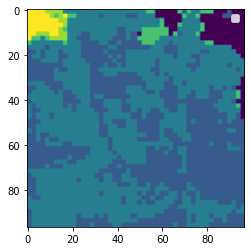

In [13]:
plt.imshow(np.array(image))